## Visualization of different validation techniques

Comparison between "Fast.AI's Rectangular Image Crop", "Imagenet Center Crop", "Test Time Augmentation"

In [1]:
import os, sys, shutil, time, warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from tqdm import tqdm
import urllib.request

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import Sampler


In [2]:
data = Path.home()/'data/imagenet'
valdir = data/'validation'
batch_size = 128

## Map Images to Aspect ratio

In [3]:
# Step 1: sort images by aspect ratio
def sort_ar(valdir):
    idx2ar_file = data/'sorted_idxar.p'
    if os.path.isfile(idx2ar_file): return pickle.load(open(idx2ar_file, 'rb'))
    print('Sorting images by Aspect Ratio. Please be patient this may take a couple minutes...')
    val_dataset = datasets.ImageFolder(valdir)
    sizes = [img[0].size for img in tqdm(val_dataset, total=len(val_dataset))]
    idx_ar = [(i, round(s[0]/s[1], 5)) for i,s in enumerate(sizes)]
    sorted_idxar = sorted(idx_ar, key=lambda x: x[1])
    pickle.dump(sorted_idxar, open(idx2ar_file, 'wb'))
    return sorted_idxar

# Step 2: chunk images by batch size. This way we can crop each image to the batch aspect ratio mean 
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in range(0, len(l), n))

# Step 3: map image index to batch aspect ratio mean so our transform function knows where to crop
def map_idx2ar(idx_ar_sorted, batch_size):
    ar_chunks = list(chunks(idx_ar_sorted, batch_size))
    idx2ar = {}
    for chunk in ar_chunks:
        idxs, ars = list(zip(*chunk))
        mean = round(np.mean(ars), 5)
        for idx in idxs:
            idx2ar[idx] = mean
    return idx2ar

In [4]:
idx_ar_sorted = sort_ar(valdir)

#### OR just download the precomputed indexes

In [5]:
idx2ar_path = data/'sorted_idxar.p'
url = 'https://s3-us-west-2.amazonaws.com/ashaw-fastai-imagenet/sorted_idxar.p'
if not idx2ar_path.exists(): urllib.request.urlretrieve(url, idx2ar_path)
idx_ar_sorted = sort_ar(valdir)

#### Let's make sure it's sorted

In [6]:
print('First five:', idx_ar_sorted[:5])
print('Last five:', idx_ar_sorted[-5:])

First five: [(24381, 0.20427), (31757, 0.26728), (39886, 0.27256), (21302, 0.28111), (21333, 0.3175)]
Last five: [(21629, 3.86301), (38868, 4.53237), (25514, 4.70707), (38211, 5.30363), (34168, 5.8626)]


### Rectangular Dataset Preparation

In [7]:
class RectangularCropTfm(object):
    def __init__(self, idx2ar, target_size):
        self.idx2ar, self.target_size = idx2ar, target_size
    def __call__(self, img, idx):
        target_ar = self.idx2ar[idx]
        if target_ar < 1: 
            w = int(self.target_size/target_ar)
            size = (w//8*8, self.target_size)
        else: 
            h = int(self.target_size*target_ar)
            size = (self.target_size, h//8*8)
        return transforms.functional.center_crop(img, size)


class ValDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform, target_transform)
    def __getitem__(self, index):
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            for tfm in self.transform:
                if isinstance(tfm, RectangularCropTfm): sample = tfm(sample, index)
                else: sample = tfm(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target


### Test validation with aspect ratio transforms

In [8]:
val_bs = 128
idx2ar = map_idx2ar(idx_ar_sorted, val_bs)
target_size = 128

In [9]:
# Rect
val_ar_tfms = [transforms.Resize(int(target_size*1.14)), RectangularCropTfm(idx2ar, target_size)]
val_dataset_ar = ValDataset(valdir, val_ar_tfms)

# No transforms
orig_dataset = datasets.ImageFolder(valdir, transforms.Resize(target_size))

val_tfms = [transforms.Resize(int(target_size*1.14)), transforms.CenterCrop(target_size)]
val_dataset = datasets.ImageFolder(valdir,  transforms.Compose(val_tfms))

min_scale = 0.5
trn_tfms = [
        transforms.RandomResizedCrop(target_size, scale=(min_scale, 1.0)),
        transforms.RandomHorizontalFlip(),
    ]
tta_aug_dataset = datasets.ImageFolder(valdir, transforms.Compose(trn_tfms))


In [10]:
def show_validation_image(sorted_index, figsize=(10,10)):
    index, aspect_ratio = idx_ar_sorted[sorted_index]
    print('Aspect ratio:', aspect_ratio)
    f, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=figsize)
    f.tight_layout(h_pad=6.0)
    fontsize = 15
    ax1[0].imshow(orig_dataset[index][0])
    ax1[0].set_title('Center Crop Image', fontsize=fontsize)
    ax1[1].imshow(val_dataset_ar[index][0])
    ax1[1].set_title('FastAi Rectangular Crop', fontsize=fontsize)
    ax2[0].imshow(val_dataset[index][0])
    ax2[0].set_title('Imagenet Center Crop', fontsize=fontsize)
    ax2[1].imshow(tta_aug_dataset[index][0])
    ax2[1].set_title('Test Time Augmentation 1', fontsize=fontsize)
    ax3[0].imshow(tta_aug_dataset[index][0])
    ax3[0].set_title('Test Time Augmentation 2', fontsize=fontsize)
    ax3[1].imshow(tta_aug_dataset[index][0])
    ax3[1].set_title('Test Time Augmentation 3', fontsize=fontsize)

### Let's see what tall images look like (Aspect ratio < 1)

Lots of these images are objects or figures. Helps to see the whole thing

Aspect ratio: 0.43085


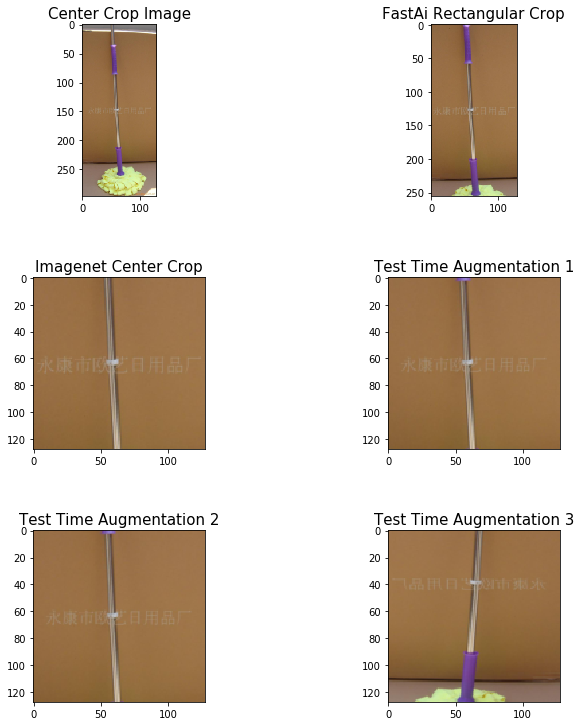

In [11]:
show_validation_image(22)

Aspect ratio: 0.46


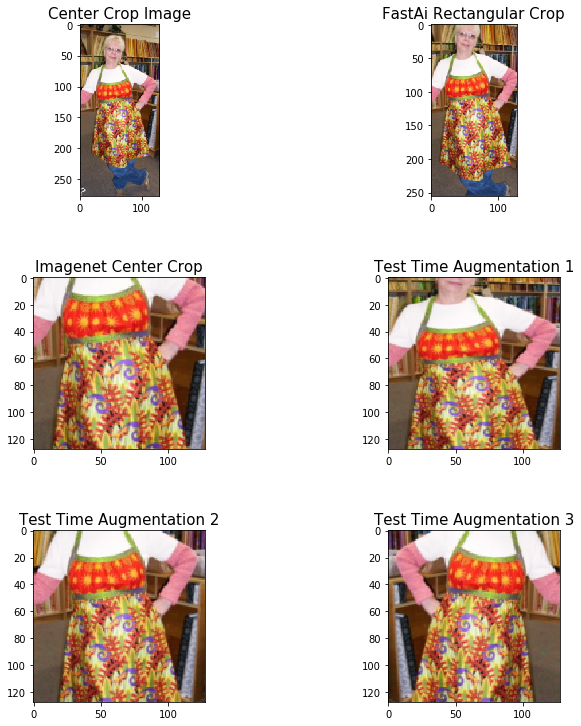

In [12]:
show_validation_image(32)

### Wide images (Aspect ratio > 1)

Aspect ratio: 3.86301


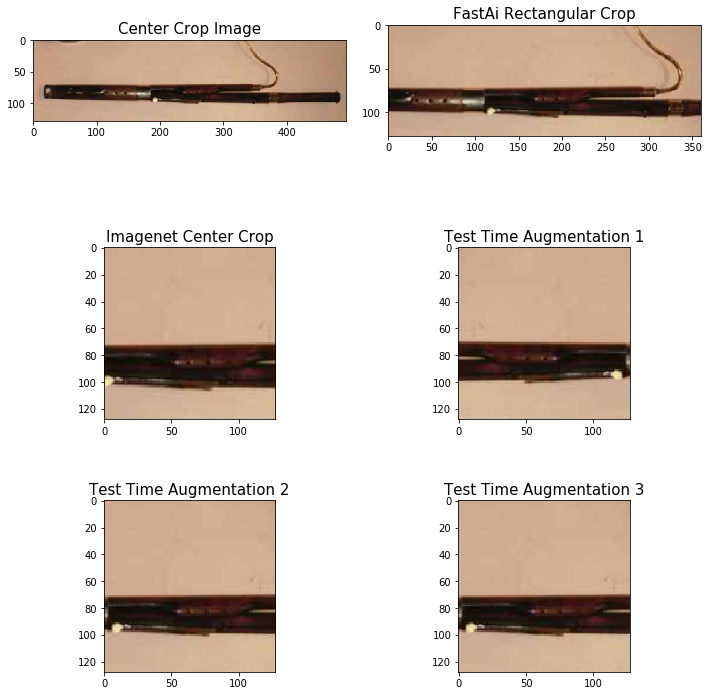

In [13]:
show_validation_image(-5)

Aspect ratio: 2.91925


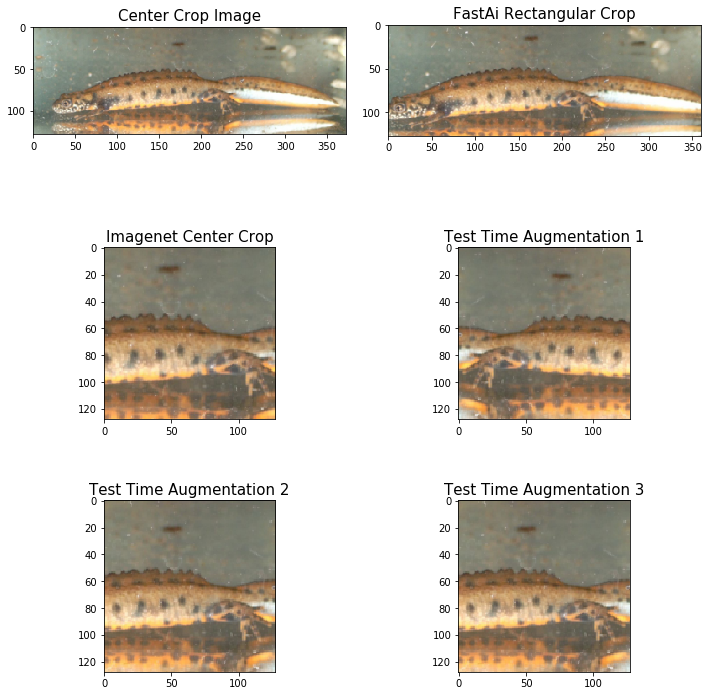

In [14]:
show_validation_image(-23)

### Already square images - Aspect ratio ~1

Not much data loss here:

Aspect ratio: 1.08932


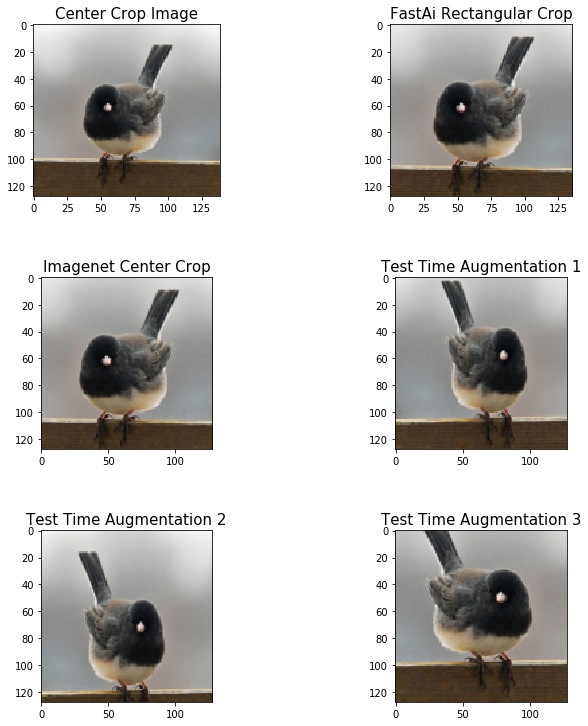

In [15]:
show_validation_image(len(idx_ar_sorted)//3)